In [1]:
import re
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
E13 = pd.read_csv("Combined_E13.csv")
FSF = pd.read_csv("Combined_FSF.csv")
INT = pd.read_csv("Combined_INT.csv")
TFP = pd.read_csv("Combined_TFP.csv")
TWT = pd.read_csv("Combined_TWT.csv")

In [4]:
E13 = E13.sample(1000)
FSF  = FSF.sample(1000)
INT = INT.sample(1000)
TFP = TFP.sample(1000)
TWT = TWT.sample(1000)

In [5]:
E13['Label'] = ["Human" for i in range(E13.shape[0])]
FSF['Label'] = ["Fake" for i in range(FSF.shape[0])]
INT['Label'] = ["Fake" for i in range(INT.shape[0])]
TFP['Label'] = ["Human" for i in range(TFP.shape[0])]
TWT['Label'] = ["Fake" for i in range(TWT.shape[0])]

In [6]:
df = pd.concat([E13, FSF, INT, TFP, TWT])
print("Complete dataset shape: ", df.shape)

Complete dataset shape:  (5000, 35)


In [7]:
df.head()

,user_id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,profile_image_url,...,in_reply_to_user_id,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,tweet_created_year,tweet_created_month,tweet_created_day,Label
1379721,432377556,Carlo Mazzocca,carlomazzocca,1549,354,214,1,3.0,it,http://a0.twimg.com/profile_images/2684696294/...,...,0,0,0.0,1,0,0,2012,4,1,Human
768368,206615715,Eve's Lost Control,EveBlissett,5311,1249,886,296,37.0,it,http://a0.twimg.com/profile_images/3051400897/...,...,0,0,1.0,1,1,1,2012,6,9,Human
424486,85305729,âˆ†aft Jump,iMightBeWrong,4043,126,126,98,1.0,it,http://a0.twimg.com/profile_images/3233742678/...,...,0,0,0.0,0,0,0,2011,12,27,Human
1162670,383292062,ilPux,MarcoPusceddu1,222,125,300,20,0.0,it,http://a0.twimg.com/profile_images/2674480298/...,...,0,213,0.0,0,0,1,2012,6,22,Human
2000158,154588620,eyes like catwoman,she_died,22534,715,792,141,2.0,it,http://a0.twimg.com/profile_images/3434996804/...,...,0,7,0.0,1,0,1,2013,2,17,Human


In [8]:
# Dropping the rows containing the null values
df.dropna(inplace=True)

In [9]:
# Define the preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # Perform stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in filtered_tokens]
    # Join the tokens back into a single string
    preprocessed_text = ' '.join(stemmed_tokens)
    return preprocessed_text

In [10]:
# Apply the preprocessing function to the text column
df['text'] = df['text'].apply(preprocess_text)

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Create a bag-of-words representation
vectorizer = CountVectorizer(max_features=100)
vectorized = vectorizer.fit_transform(df['text'])

In [12]:
vectorized_data = np.array(vectorized.toarray())

In [13]:
vectorized_df = pd.DataFrame(vectorized_data, columns=vectorizer.get_feature_names())

In [14]:
vectorized_df = vectorized_df.reset_index()

In [15]:
# vectorized_df.shape
df = df.reset_index()

In [16]:
com_df = pd.concat([vectorized_df, df], axis=1)

In [17]:
com_df.head()

,index,ad,al,all,amp,anch,back,berlusconi,che,chi,...,in_reply_to_user_id,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,tweet_created_year,tweet_created_month,tweet_created_day,Label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0.0,1,0,0,2012,4,1,Human
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1.0,1,1,1,2012,6,9,Human
2,2,0,0,0,0,0,0,0,1,0,...,0,0,0.0,0,0,0,2011,12,27,Human
3,3,0,0,0,0,0,0,0,0,0,...,0,213,0.0,0,0,1,2012,6,22,Human
4,4,0,0,0,0,0,0,0,0,0,...,0,7,0.0,1,0,1,2013,2,17,Human


In [18]:
com_df.drop('index', axis=1, inplace=True)

In [19]:
from sklearn.preprocessing import LabelEncoder

# Label encoding the column containing the string type data
str_type_col = [col for col in com_df.columns if com_df[col].dtype == object]

le_dic = {}
for col in str_type_col:
    print(col)
    le = LabelEncoder()
    com_df[col] = le.fit_transform(com_df[col].astype(str))
    le_dic[col] = le

name
screen_name
lang
profile_image_url
profile_background_image_url_https
profile_text_color
profile_image_url_https
profile_sidebar_border_color
profile_sidebar_fill_color
profile_background_image_url
profile_background_color
profile_link_color
text
source
Label


In [20]:
df.nunique()

index                                 3967
user_id                               1743
name                                  1736
screen_name                           1743
statuses_count                        1035
followers_count                        543
friends_count                          827
favourites_count                       414
listed_count                            80
lang                                    13
profile_image_url                     1741
profile_background_image_url_https     574
profile_text_color                     151
profile_image_url_https               1741
profile_sidebar_border_color           106
profile_sidebar_fill_color             168
profile_background_image_url           563
profile_background_color               210
profile_link_color                     289
account_creation_day                    31
account_creation_month                  12
account_creation_year                    8
id                                    4000
text       

In [21]:
from sklearn.model_selection import train_test_split

# Extract the target and feature columns
X = com_df.iloc[:,:-1]
y = com_df.iloc[:, -1]

# Spliting the dataset into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Displaying the train and test data shape
print("Train data:", X_train.shape)
print("Test data:", X_test.shape)

Train data: (2680, 134)
Test data: (1320, 134)


In [22]:
# Models Importing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

# For Model Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [23]:
# function for evaluation metrics precision, recall, f1 etc
def modelEvaluation(predictions, y_test_set, model_name):
    # Print model evaluation to predicted result    
    print("==========",model_name,"==========")
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))    
    print ("\nClassification report : \n", classification_report(y_test_set, predictions))
    print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set, predictions))
    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test_set, predictions),annot=True, fmt='g',cmap='viridis')
    plt.tight_layout()
    plt.show()
    results = [accuracy_score(y_test_set, predictions), precision_score(y_test_set, predictions, average='macro'),
              recall_score(y_test_set, predictions, average='macro'),f1_score(y_test_set, predictions, average='macro')]
    return results

========== Decision tree ==========

Accuracy on validation set: 0.9212

Classification report : 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       970
           1       0.88      0.82      0.85       350

    accuracy                           0.92      1320
   macro avg       0.91      0.89      0.90      1320
weighted avg       0.92      0.92      0.92      1320


Confusion Matrix : 
 [[930  40]
 [ 64 286]]


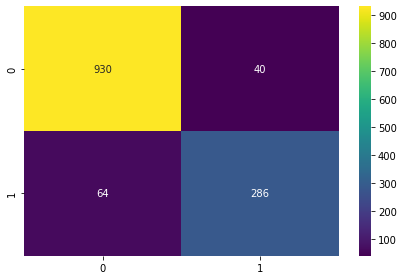

========== Random Forest ==========

Accuracy on validation set: 0.9424

Classification report : 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       970
           1       0.96      0.81      0.88       350

    accuracy                           0.94      1320
   macro avg       0.95      0.90      0.92      1320
weighted avg       0.94      0.94      0.94      1320


Confusion Matrix : 
 [[959  11]
 [ 65 285]]


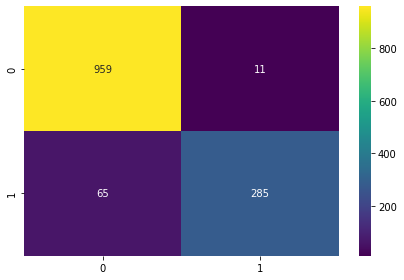

========== Naive Bayes ==========

Accuracy on validation set: 0.7023

Classification report : 
               precision    recall  f1-score   support

           0       0.77      0.85      0.81       970
           1       0.41      0.29      0.34       350

    accuracy                           0.70      1320
   macro avg       0.59      0.57      0.57      1320
weighted avg       0.67      0.70      0.68      1320


Confusion Matrix : 
 [[827 143]
 [250 100]]


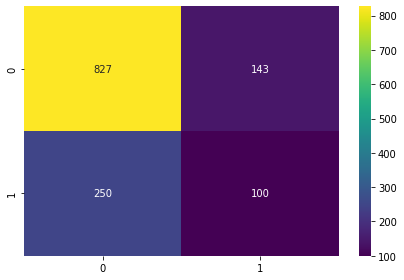

========== Logistic Regression ==========

Accuracy on validation set: 0.7348

Classification report : 
               precision    recall  f1-score   support

           0       0.73      1.00      0.85       970
           1       0.00      0.00      0.00       350

    accuracy                           0.73      1320
   macro avg       0.37      0.50      0.42      1320
weighted avg       0.54      0.73      0.62      1320


Confusion Matrix : 
 [[970   0]
 [350   0]]


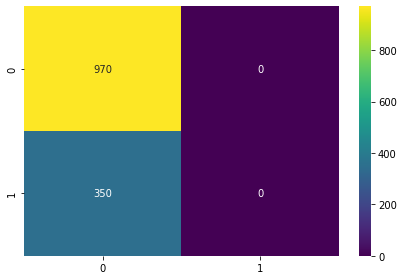

In [24]:
# For Decision tree Classifier
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
pred_dt = dt_model.predict(X_test)
result_dt = modelEvaluation(pred_dt, y_test, 'Decision tree')

# For Random Forest Classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
pred_rf = rf_model.predict(X_test)
result_rf = modelEvaluation(pred_rf, y_test, 'Random Forest')

# Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_train,y_train)
pred_nb = nb_model.predict(X_test)
results_nb = modelEvaluation(pred_nb, y_test, 'Naive Bayes')

# For Logistic Regression Classifier
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
pred_lr = lr_model.predict(X_test)
results_lr = modelEvaluation(pred_lr, y_test, 'Logistic Regression')

In [25]:
# Defining Hyperparameters grid
rfc_param = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10]}

mnb_param = {'alpha': [0.1, 0.5, 1.0, 2.0]}

lg_param = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet']}

dt_param = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

In [26]:
# Initializing grid search CV to find the best parameters for each model.
rfc_grid_search = GridSearchCV(estimator=rf_model, param_grid=rfc_param, cv=5)
nb_grid_search = GridSearchCV(estimator=nb_model, param_grid= mnb_param, cv=5)
lr_grid_search = GridSearchCV(estimator=lr_model, param_grid=lg_param, cv=5)
dt_grid_search = GridSearchCV(estimator=dt_model, param_grid=dt_param, cv=5)

In [28]:
# Searching for Best Parameters
rfc_grid_search.fit(X, y)
dt_grid_search.fit(X, y)
nb_grid_search.fit(X, y)
lr_grid_search.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [29]:
rfc_best_params = rfc_grid_search.best_params_
nb_best_params = nb_grid_search.best_params_
lr_best_params = lr_grid_search.best_params_
dt_best_params = dt_grid_search.best_params_
print('Best Parameters for Random Forest', rfc_best_params, end = '\n-------------------------------\n')
print('Best Parameters for Naive Bayes', nb_best_params, end = '\n-------------------------------\n')
print('Best Parameters for Logistic Regression', lr_best_params, end = '\n-------------------------------\n')
print('Best Parameters for Decision Tree', dt_best_params, end = '\n-------------------------------\n')

Best Parameters for Random Forest {'max_depth': None, 'n_estimators': 200}
-------------------------------
Best Parameters for Naive Bayes {'alpha': 0.1}
-------------------------------
Best Parameters for Logistic Regression {'C': 0.001, 'penalty': 'l2'}
-------------------------------
Best Parameters for Decision Tree {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
-------------------------------


========== Decision tree ==========

Accuracy on validation set: 0.9242

Classification report : 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       970
           1       0.88      0.83      0.85       350

    accuracy                           0.92      1320
   macro avg       0.91      0.89      0.90      1320
weighted avg       0.92      0.92      0.92      1320


Confusion Matrix : 
 [[931  39]
 [ 61 289]]


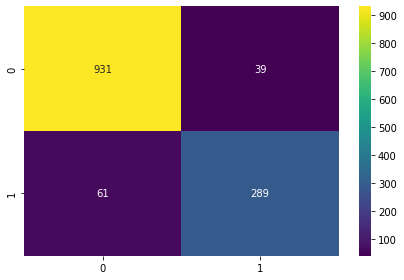

========== Random Forest ==========

Accuracy on validation set: 0.9462

Classification report : 
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       970
           1       0.96      0.83      0.89       350

    accuracy                           0.95      1320
   macro avg       0.95      0.91      0.93      1320
weighted avg       0.95      0.95      0.94      1320


Confusion Matrix : 
 [[957  13]
 [ 58 292]]


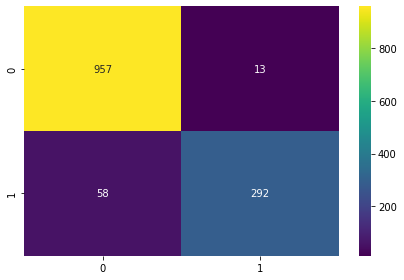

========== Naive Bayes ==========

Accuracy on validation set: 0.7023

Classification report : 
               precision    recall  f1-score   support

           0       0.77      0.85      0.81       970
           1       0.41      0.29      0.34       350

    accuracy                           0.70      1320
   macro avg       0.59      0.57      0.57      1320
weighted avg       0.67      0.70      0.68      1320


Confusion Matrix : 
 [[827 143]
 [250 100]]


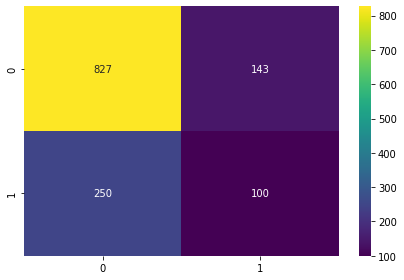

========== Logistic Regression ==========

Accuracy on validation set: 0.7348

Classification report : 
               precision    recall  f1-score   support

           0       0.73      1.00      0.85       970
           1       0.00      0.00      0.00       350

    accuracy                           0.73      1320
   macro avg       0.37      0.50      0.42      1320
weighted avg       0.54      0.73      0.62      1320


Confusion Matrix : 
 [[970   0]
 [350   0]]


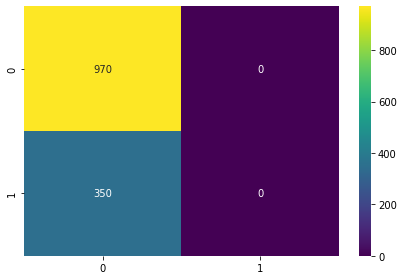

In [30]:
# For Decision tree Classifier
dt_model = DecisionTreeClassifier(**dt_best_params)
dt_model.fit(X_train, y_train)
pred_dt = dt_model.predict(X_test)
result_dt2 = modelEvaluation(pred_dt, y_test, 'Decision tree')

# For Random Forest Classifier
rf_model = RandomForestClassifier(**rfc_best_params)
rf_model.fit(X_train, y_train)
pred_rf = rf_model.predict(X_test)
result_rf2 = modelEvaluation(pred_rf, y_test, 'Random Forest')

# Naive Bayes Classifier
nb_model = MultinomialNB(**nb_best_params)
nb_model.fit(X_train,y_train)
pred_nb = nb_model.predict(X_test)
results_nb2 = modelEvaluation(pred_nb, y_test, 'Naive Bayes')

# For Logistic Regression Classifier
lr_model = LogisticRegression(**lr_best_params)
lr_model.fit(X_train, y_train)
pred_lr = lr_model.predict(X_test)
results_lr2 = modelEvaluation(pred_lr, y_test, 'Logistic Regression')

In [31]:
comparison = {'Models': ['Decision Tree', 'Random Forest', 'Naive Bayes', 'Logistic Regression'],
             'Accuracy B/T': [result_dt[0], result_rf[0], results_nb[0], results_lr[0]],
             'Accuracy A/T': [result_dt2[0], result_rf2[0], results_nb2[0], results_lr2[0]],
              'Percision B/T': [result_dt[1], result_rf[1], results_nb[1], results_lr[1]],
             'Percision A/T': [result_dt2[1], result_rf2[1], results_nb2[1], results_lr2[1]],
             'Recall B/T': [result_dt[2], result_rf[2], results_nb[2], results_lr[2]],
             'Recall A/T': [result_dt2[2], result_rf2[2], results_nb2[2], results_lr2[2]],
             'F1-score B/T': [result_dt[3], result_rf[3], results_nb[3], results_lr[3]],
             'F1-score A/T': [result_dt2[3], result_rf2[3], results_nb2[3], results_lr2[3]]}
df_acc = pd.DataFrame(comparison)
df_acc

,Models,Accuracy B/T,Accuracy A/T,Percision B/T,Percision A/T,Recall B/T,Recall A/T,F1-score B/T,F1-score A/T
0,Decision Tree,0.921212,0.924242,0.906457,0.909803,0.887953,0.892754,0.896600,0.900769
1,Random Forest,0.942424,0.946212,0.949681,0.950117,0.901473,0.910442,0.922119,0.927917
2,Naive Bayes,0.702273,0.702273,0.589698,0.589698,0.569146,0.569146,0.572640,0.572640
3,Logistic Regression,0.734848,0.734848,0.367424,0.367424,0.500000,0.500000,0.423581,0.423581


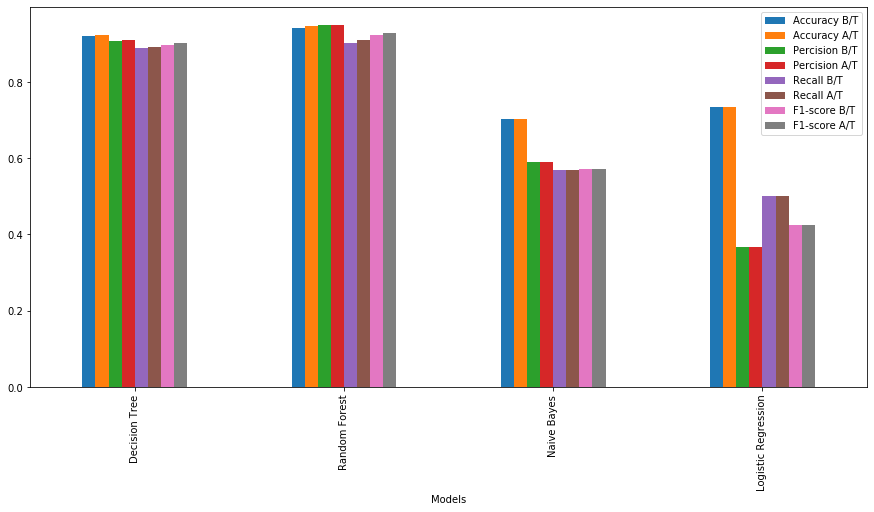

In [32]:
df_acc.set_index("Models").plot(kind='bar', figsize=(15,7))

========== SVM ==========

Accuracy on validation set: 0.7348

Classification report : 
               precision    recall  f1-score   support

           0       0.73      1.00      0.85       970
           1       0.00      0.00      0.00       350

    accuracy                           0.73      1320
   macro avg       0.37      0.50      0.42      1320
weighted avg       0.54      0.73      0.62      1320


Confusion Matrix : 
 [[970   0]
 [350   0]]


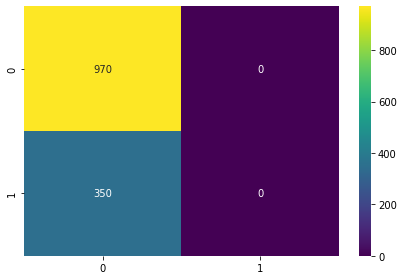

In [33]:
from sklearn.svm import SVC

# Create the SVM model
svm_model = SVC()

# Fit the model to the training data
svm_model.fit(X_train, y_train)

# Make predictions on the test data
pred_svm = svm_model.predict(X_test)

# Evaluate the model
results_svm = modelEvaluation(pred_svm, y_test, 'SVM')

========== GBM ==========

Accuracy on validation set: 0.9303

Classification report : 
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       970
           1       0.91      0.82      0.86       350

    accuracy                           0.93      1320
   macro avg       0.92      0.90      0.91      1320
weighted avg       0.93      0.93      0.93      1320


Confusion Matrix : 
 [[940  30]
 [ 62 288]]


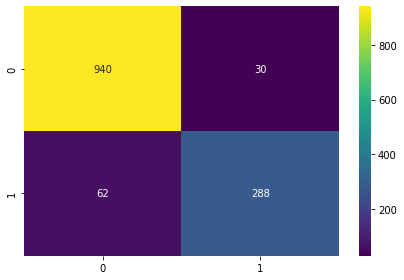

In [34]:
from sklearn.ensemble import GradientBoostingClassifier

# Create the GBM model
gbm_model = GradientBoostingClassifier()

# Fit the model to the training data
gbm_model.fit(X_train, y_train)

# Make predictions on the test data
pred_gbm = gbm_model.predict(X_test)

# Evaluate the model
results_gbm = modelEvaluation(pred_gbm, y_test, 'GBM')

========== Neural Network ==========

Accuracy on validation set: 0.7303

Classification report : 
               precision    recall  f1-score   support

           0       0.73      0.99      0.84       970
           1       0.00      0.00      0.00       350

    accuracy                           0.73      1320
   macro avg       0.37      0.50      0.42      1320
weighted avg       0.54      0.73      0.62      1320


Confusion Matrix : 
 [[964   6]
 [350   0]]


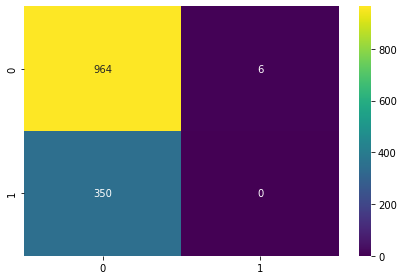

In [37]:
from sklearn.neural_network import MLPClassifier

# Create the Neural Network model
nn_model = MLPClassifier()

# Fit the model to the training data
nn_model.fit(X_train, y_train)

# Make predictions on the test data
pred_nn = nn_model.predict(X_test)

# Evaluate the model
results_nn = modelEvaluation(pred_nn, y_test, 'Neural Network')

In [41]:
comparison1 = {
    'Models': ['SVM', 'GradientBoosting', 'Neural Network'],
    'Accuracy': [results_svm[0], results_gbm[0], results_nn[0]],
    'Precision': [results_svm[1], results_gbm[1], results_nn[1]],
    'Recall': [results_svm[2], results_gbm[2], results_nn[2]],
    'F1-score': [results_svm[3], results_gbm[3], results_nn[3]]
}

df_acc = pd.DataFrame(comparison1)
df_acc

,Models,Accuracy,Precision,Recall,F1-score
0,SVM,0.734848,0.367424,0.500000,0.423581
1,GradientBoosting,0.930303,0.921892,0.895965,0.907811
2,Neural Network,0.730303,0.366819,0.496907,0.422067


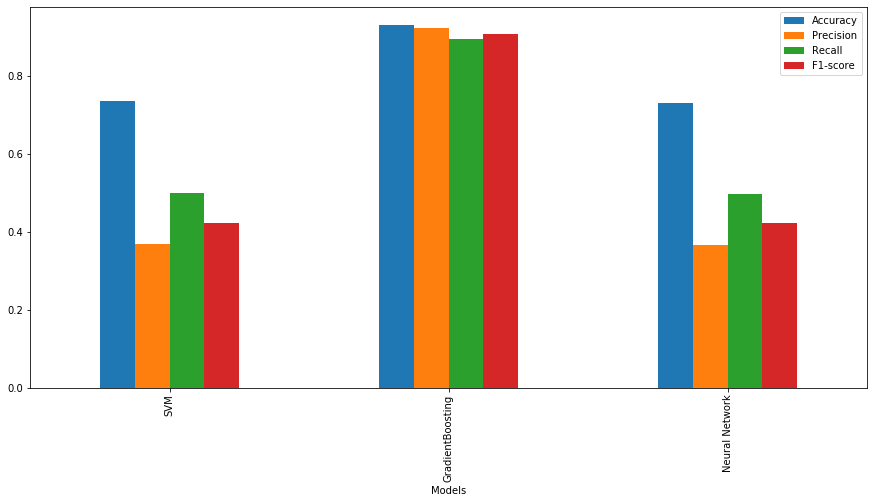

In [42]:
df_acc.set_index("Models").plot(kind='bar', figsize=(15,7))